# Creating a Scikit-Learn Model to Predict News Article Reliability

### Dependencies

In [19]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import classification_report
import math

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thken\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import first dataset (found at https://www.kaggle.com/pontes/fake-news-sample)

In [2]:
data1 = pd.read_csv('../FakeNewsSample/resized_v2.csv')
data1 = data1[['title', 'content', 'type']]
data1['type'] = data1['type'].apply(lambda x : 'unreliable' if x != 'reliable' else x)
data1.head()

C:\Users\thken\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,title,content,type
0,Email Protection,The website from which you got to this page is...,unreliable
1,malcolm turnbull satire – The Shovel,"For as long as he can remember, Malcolm Turnbu...",unreliable
2,What Western Imperialism Is Up to Now in Zimbabwe,What Western Imperialism Is Up to Now in Zimba...,unreliable
3,WOW! Iranian-Canadian protesters love Donald T...,We appreciate your help! Click here to donate\...,unreliable
4,Black Agenda Report,“The massacre of the mine workers in August of...,unreliable


### Import second dataset (found at https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset/)

In [4]:
true = pd.read_csv('../FakeRealNews/True.csv')
true = true[['title', 'text']]
true['type'] = 'reliable'
true.head()

,title,text,type
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,reliable
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,reliable
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,reliable
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,reliable
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,reliable


In [5]:
fake = pd.read_csv('../FakeRealNews/Fake.csv')
fake = fake[['title', 'text']]
fake['type'] = 'unreliable'
fake.head()

,title,text,type
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,unreliable
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,unreliable
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",unreliable
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",unreliable
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,unreliable


In [6]:
data2 = pd.concat([true, fake])
data2.columns = ['title', 'content', 'type']
data2.head()

,title,content,type
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,reliable
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,reliable
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,reliable
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,reliable
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,reliable


#### Combine both datasets into one DataFrame

In [7]:
df = pd.concat([data1, data2])

### Clean data using regular expressions

In [8]:
def regex_clean(data):
    contents = []
    for content in data:
        try:
            temp = content.lower()
            temp = re.sub('u\.s\.', 'us', temp)
            temp = re.sub('\n|\r', ' ', temp)
            temp = re.sub("’|'", '', temp)
            temp = re.sub('\.', ' ', temp)
            temp = re.sub('e-mail', 'email', temp)
            temp = re.sub('(\[.*\])', ' ', temp)
            temp = re.sub("[^0-9^a-z^ ]", " ", temp)
            temp = re.sub('https?\S+', ' ', temp)
            temp = re.sub('[0-9]\S*', ' ', temp)
            temp = re.sub(' {2,}', ' ', temp)
            temp = temp.strip()
            contents.append(temp)
        except:
            contents.append(None)

    return contents

In [9]:
df['content'] = regex_clean(df['content'])
df['title'] = regex_clean(df['title'])
df = df.dropna()
df.head()

,title,content,type
0,email protection,the website from which you got to this page is...,unreliable
1,malcolm turnbull satire the shovel,for as long as he can remember malcolm turnbul...,unreliable
2,what western imperialism is up to now in zimbabwe,what western imperialism is up to now in zimba...,unreliable
3,wow iranian canadian protesters love donald tr...,we appreciate your help click here to donate c...,unreliable
4,black agenda report,the massacre of the mine workers in august of ...,unreliable


In [10]:
df['title_length'] = df['title'].apply(lambda x : len(x.split(' ')))
df['content_length'] = df['content'].apply(lambda x : len(x.split(' ')))

### Remove class bias

In [11]:
reliable = df[df['type'] == 'reliable']
unreliable = df[df['type'] == 'unreliable']

In [12]:
len(reliable)

117441

In [13]:
len(unreliable)

350365

In [14]:
unreliable = unreliable.sample(n=len(reliable), random_state=10)
df = pd.concat([reliable, unreliable])

#### One-hot encode the response variable

In [15]:
df['type'] = df['type'].apply(lambda x : 1 if x == 'reliable' else 0)

In [16]:
rand_state = 10

### Build the content model

In [17]:
X_c_train, X_c_test, y_train, y_test = train_test_split(df['content'], df['type'], test_size=0.2, random_state=rand_state)

#### Create a pipeline that converts contents to TFIDF vectors and trains a Logistic Regression Classifier with Stochastic Gradient Descent

In [20]:
pipe_c = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                   ('sgd', SGDClassifier(loss='log', penalty='l2', alpha=1e-6, random_state=rand_state, max_iter=10, tol=None))
                  ])
pipe_c.fit(X_c_train, y_train)

C:\Users\thken\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...dom_state=10, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [21]:
train, test, y_train, y_test = train_test_split(df[['title', 'content', 'type', 'title_length', 'content_length']], df['type'], test_size=0.2, random_state=rand_state)

In [22]:
test['content_pred'] = pipe_c.predict(X_c_test)
train['content_pred'] = pipe_c.predict(X_c_train)

In [23]:
print(classification_report(test['type'], test['content_pred']))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     23531
           1       0.95      0.93      0.94     23446

   micro avg       0.94      0.94      0.94     46977
   macro avg       0.94      0.94      0.94     46977
weighted avg       0.94      0.94      0.94     46977



In [ ]:
joblib.dump(pipe_c, 'models/c_final_sgd_log_1_1.joblib')

### Build the title model

In [24]:
X_t_train, X_t_test, y_train, y_test = train_test_split(df['title'], df['type'], test_size=0.2, random_state=rand_state)

#### Create a pipeline that converts contents to TFIDF vectors and trains a Multinomial Naive Bayes Classifier

In [25]:
pipe_t = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))), ('MNB', MultinomialNB())])
pipe_t.fit(X_t_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,...rue,
        vocabulary=None)), ('MNB', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [26]:
test['title_pred'] = pipe_t.predict(X_t_test)
train['title_pred'] = pipe_t.predict(X_t_train)

In [27]:
print(classification_report(test['type'], test['title_pred']))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82     23531
           1       0.81      0.84      0.82     23446

   micro avg       0.82      0.82      0.82     46977
   macro avg       0.82      0.82      0.82     46977
weighted avg       0.82      0.82      0.82     46977



In [ ]:
joblib.dump(pipe_t, 'models/t_final_mnb_1_2.joblib')

### Get probability values from the models

In [28]:
def get_probs(clf, X):
    probs = []
    for p in clf.predict_proba(X):
        probs.append(p[1])
    return probs

In [29]:
test['content_pred_prob'] = get_probs(pipe_c, X_c_test)
train['content_pred_prob'] = get_probs(pipe_c, X_c_train)

In [30]:
test['title_pred_prob'] = get_probs(pipe_t, X_t_test)
train['title_pred_prob'] = get_probs(pipe_t, X_t_train)

In [31]:
cols = ['type', 'title_length', 'content_length', 'content_pred','content_pred_prob', 'title_pred', 'title_pred_prob']
train[cols].to_csv('data/train.csv', index=None)
test[cols].to_csv('data/test.csv', index=None)

### Run the logistic_model.R script using train.csv and test.csv to get the following beta values

In [35]:
def calc_logit(df):
    b0 = -9.2371880
    b1 = 9.3777393
    b2 = 8.6144912 
    b3 = 0.9323086
    
    combined_probs = []
    for i in range(len(df)):
        x1 = df['title_pred_prob'].iloc[i]
        x2 = df['content_pred_prob'].iloc[i]
        p = (math.e ** (b0 + b1 * x1 + b2 * x2 + b3 * x1 * x2)) / (1 + (math.e ** (b0 + b1 * x1 + b2 * x2 + b3 * x1 * x2)))
        combined_probs.append(p)
    return combined_probs

In [36]:
test['combined_prob'] = calc_logit(test)
train['combined_prob'] = calc_logit(train)

test['combined_pred'] = test['combined_prob'].apply(lambda x : 1 if x >= 0.5 else 0)
train['combined_pred'] = train['combined_prob'].apply(lambda x : 1 if x >= 0.5 else 0)

In [37]:
print(classification_report(test['type'], test['combined_pred']))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     23531
           1       0.95      0.95      0.95     23446

   micro avg       0.95      0.95      0.95     46977
   macro avg       0.95      0.95      0.95     46977
weighted avg       0.95      0.95      0.95     46977



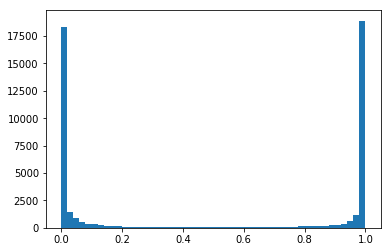

In [38]:
plt.hist(test['combined_prob'], bins=50)
plt.show()